# Playground Series - Season 4, Episode 1 - Binary Classification with a Bank Churn Dataset

In [34]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
from datetime import datetime as dt

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

#notebook settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#sklearn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, Binarizer, LabelEncoder, OneHotEncoder, TargetEncoder, LabelEncoder, OrdinalEncoder
# metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc, accuracy_score
# imbalanced datasets
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import TomekLinks,RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
# model selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
# pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.utils import class_weight

#calibration
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve

## READING FILES

**Bank Customer Churn Dataset**

The Bank Customer Churn Dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be customers. The dataset includes the following attributes:
- Customer ID: A unique identifier for each customer.
- Surname: The customer's surname or last name.
- Credit Score: A numerical value representing the customer's credit score.
- Geography: The country where the customer resides (France, Spain, or Germany).
- Gender: The customer's gender (Male or Female).
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank.
- Balance: The customer's account balance.
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card).
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no).
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no).
- EstimatedSalary: The estimated salary of the customer.
- Exited: Whether the customer has churned (1 = yes, 0 = no).

In [35]:
train_df = pd.read_csv('data/train.csv', index_col='id')
test_df = pd.read_csv('data/test.csv',index_col='id')
submission = pd.read_csv('data/sample_submission.csv')

## 1) EDA - Exploratory Data Analysis

### 1.1) Checking for missing values

In [36]:
train_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [37]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [38]:
test_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [39]:
test_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


No missing Values in train and test data 😃✅

### 1.2) Checking for duplicated values

In [40]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


No duplicated Values in train and test data 😃✅

### 1.3) Size of train and test data

In [41]:
print(train_df.shape)
print(test_df.shape)

(165034, 13)
(110023, 12)


### 1.4) Uniques values

In [42]:
# let's start looking at the training data
train_df.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

### 1.5) data type information

In [43]:
train_df.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64


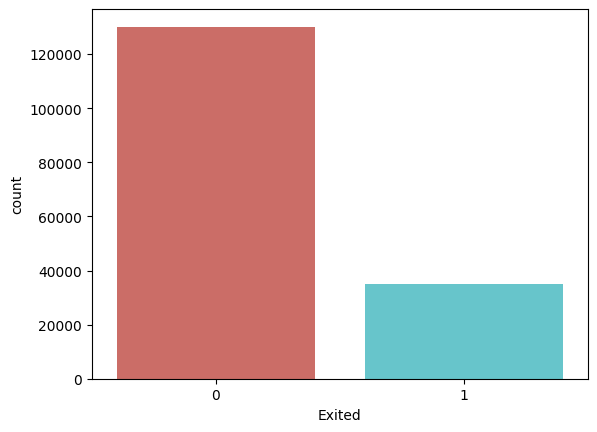

In [44]:
# let's look at the target variable
print(train_df['Exited'].value_counts(normalize=True))


# let's look at the distribution of the target variable
sns.countplot(x='Exited', data=train_df, palette='hls'); #imbalanced dataset

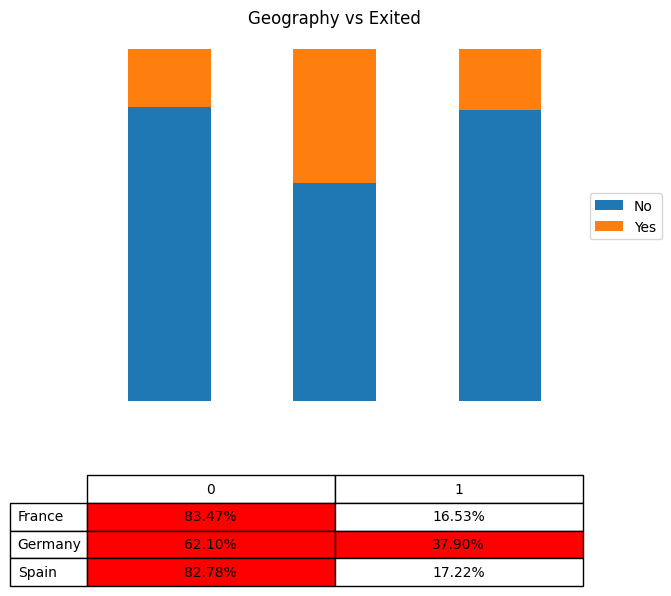

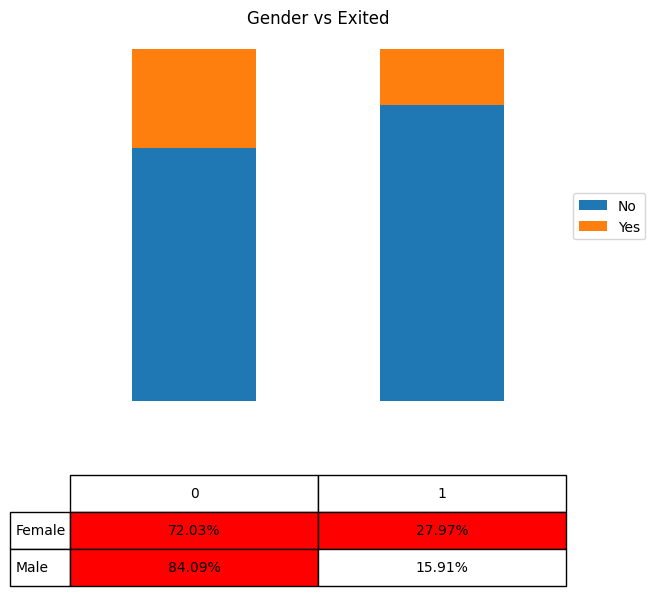

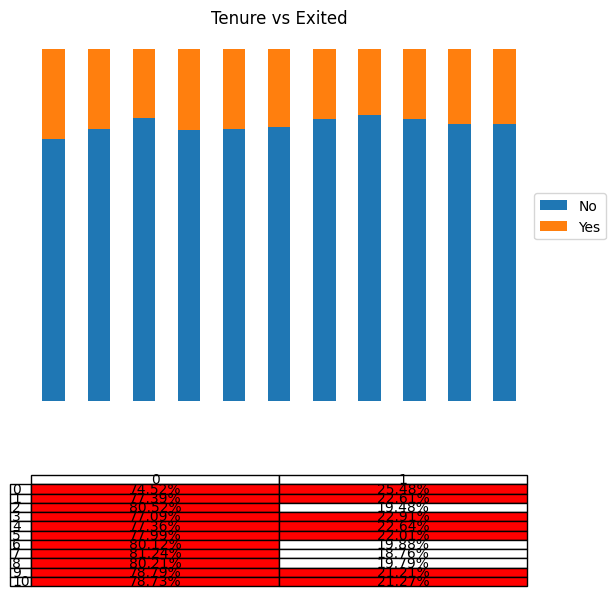

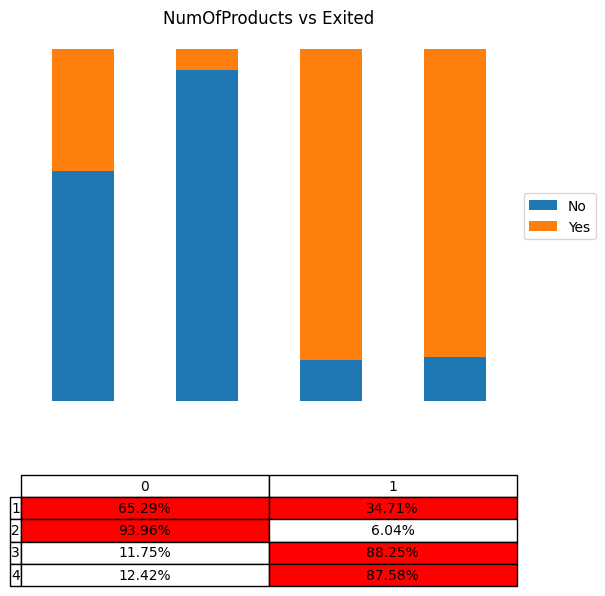

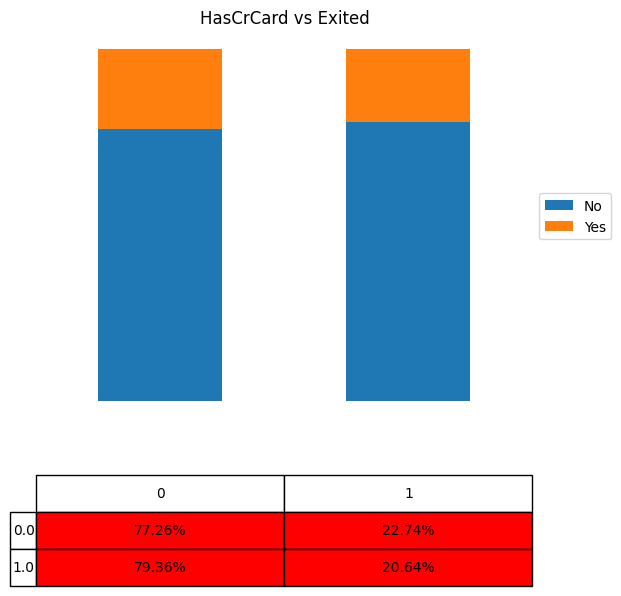

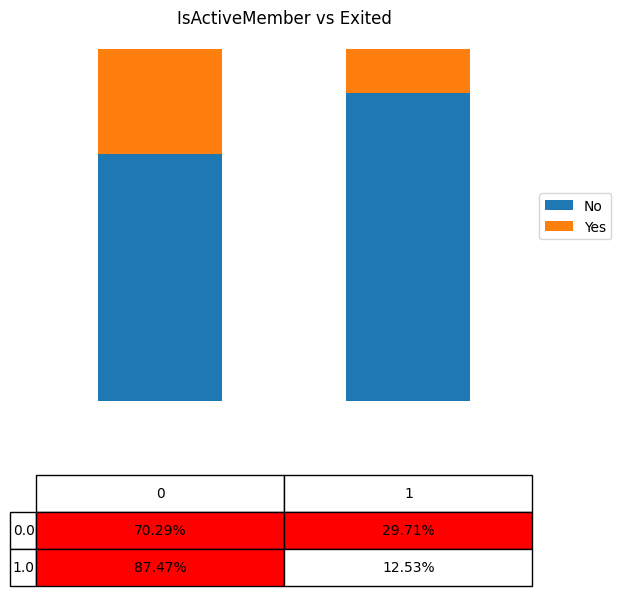

In [45]:
# checking proportions or target variable for categorical and numerical variables with unique values less than 15

def check_proportions(df, col, threshold=0.2):
    proportions = df.groupby(col)['Exited'].value_counts(normalize=True).unstack()
    proportions.plot(kind='bar', stacked=True)
    
    # Move the legend to the side of the bars
    plt.legend(['No','Yes'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    # add title
    plt.title(f'{col} vs Exited')
    
    # Create a table below the graph
    table_data = []
    cell_colors = []
    for i in range(len(proportions)):
        row_data = []
        row_colors = []
        for j in range(len(proportions.columns)):
            value = proportions.iloc[i, j]
            if value > threshold:
                row_data.append(f'{value:.2%}')
                row_colors.append('red')  # Highlight imbalanced values with red color
            else:
                row_data.append(f'{value:.2%}')
                row_colors.append('white')
        table_data.append(row_data)
        cell_colors.append(row_colors)
    
    table = plt.table(cellText=table_data,
                      colLabels=proportions.columns,
                      rowLabels=proportions.index,
                      loc='bottom',
                      cellLoc='center',
                      bbox=[0, -0.5, 1, 0.3],  # Increase the height by modifying the bbox parameter
                      cellColours=cell_colors)  # Set cell colors
    
    # Hide the axes and axis labels
    plt.axis('off')
    
    plt.show()

# selecting columns with unique values less than 15
cols = train_df.columns[train_df.nunique() < 15].tolist()
cols.remove('Exited')

# apply to all variables and plot the proportions
for col in cols:    
    check_proportions(train_df, col)


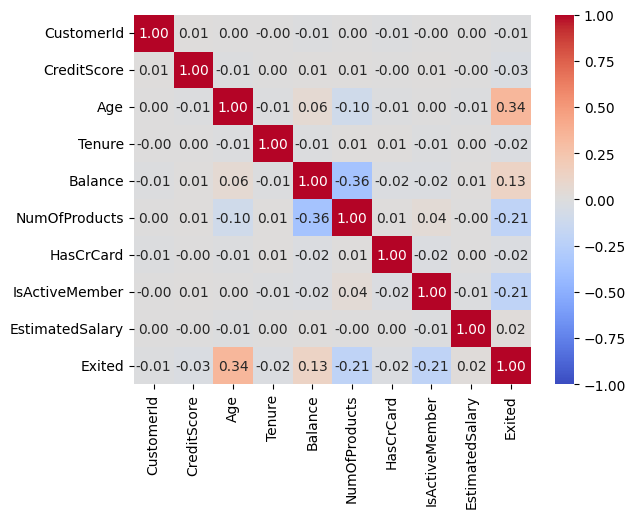

In [46]:
correlation_matrix = train_df.select_dtypes(exclude='object').corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix.round(2), 
            xticklabels=column_names, 
            yticklabels=column_names,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f");


Possible issues due to correlations:

- Exited possible issues: 
  - Age
  - Balance
  - NumOfProducts
  - IsActiveMember

- between features:
  - Balance vs NumOfProducts
  - Age vs NumOfProducts

Feature Binning:

For continuous variables like "Age" or "Balance," consider binning or discretizing them into categories. 
This can help capture non-linear relationships and reduce sensitivity to outliers.

## 2) PreProcess Data

In [47]:
# this class will help us to drop unwanted columns
class DropUnwantedColumns(BaseEstimator, TransformerMixin):
    """This class helps to drop unwanted columns."""

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        return data.drop(labels=self.columns, axis='columns')

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in self.columns]

class ColumnSelector(BaseEstimator, TransformerMixin):
    """This class helps to select columns based on their names or data types."""

    def __init__(self, columns=None, dtypes=None):
        self.columns = columns
        self.dtypes = dtypes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        if self.columns:
            data = data[self.columns]
        if self.dtypes:
            data = data.select_dtypes(include=self.dtypes)
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col in self.columns]


# selections of columns ------------------------------------------------------------
# columns for DropColumns transformer
columns_to_drop = ['CustomerId', 'Surname']

# identifying categorical and numerical features
cat_ohe_features = ['Geography','Gender'] # order does not matter
cat_ord_features = ['NumOfProducts']
num_features = ['Tenure','Age','CreditScore','Balance','EstimatedSalary']


# building a pipeline for categorical features --------------------------------------
cat_ohe_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

cat_ord_pipeline = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

# building a pipeline for numerical features ----------------------------------------
num_pipeline = Pipeline(steps=[
    ('robust_scaler', RobustScaler())
])

# let's join the numerical and categorical pipelines --------------------------------
preprocessor = ColumnTransformer(transformers=[
    ('cat_ohe', cat_ohe_pipeline, cat_ohe_features),
    ('cat_ord_features', cat_ord_pipeline, cat_ord_features),
    ('num', num_pipeline, num_features),
    ('pass', 'passthrough', ['HasCrCard', 'IsActiveMember'])
])

pipeline = Pipeline(steps=[
    ('drop_unwanted_columns', DropUnwantedColumns(columns=columns_to_drop)),
    ('preprocessor', preprocessor),
])

pipeline


Pipeline(steps=[('drop_unwanted_columns',
                 DropUnwantedColumns(columns=['CustomerId', 'Surname'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Geography', 'Gender']),
                                                 ('cat_ord_features',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['NumOfProducts']),
                                                 ('num',
                                                  Pipeline(steps=[('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'Age',
                                                   'CreditScore', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('pass', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])]))])

In [48]:
# let's test the pipeline on the training data
X_train = pipeline.fit_transform(train_df)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# create a dataframe with the transformed data and feature names
X_transformed = pd.DataFrame(X_train, columns=feature_names)

print('X_transformed shape: {}'.format(X_transformed.shape))
print('y shape: {}'.format(train_df['Exited'].shape))

# check dataframe head
X_transformed.head()

X_transformed shape: (165034, 13)
y shape: (165034,)


,cat_ohe__Geography_France,cat_ohe__Geography_Germany,cat_ohe__Geography_Spain,cat_ohe__Gender_Female,cat_ohe__Gender_Male,cat_ord_features__NumOfProducts,num__Tenure,num__Age,num__CreditScore,num__Balance,num__EstimatedSalary,pass__HasCrCard,pass__IsActiveMember
0,1.0,0.0,0.0,0.0,1.0,1.0,-0.50,-0.4,0.079646,0.000000,0.788698,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,-1.00,-0.4,-0.283186,0.000000,-0.850085,1.0,1.0
2,1.0,0.0,0.0,0.0,1.0,1.0,1.25,0.3,0.168142,0.000000,0.831134,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,-0.75,-0.3,-0.690265,1.241313,-0.414670,1.0,1.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.00,-0.4,0.504425,0.000000,-1.277766,1.0,1.0


In [60]:
# Define classifiers
# Define classifiers
params_xgb = {
    'objective': 'binary:logistic',
    'n_jobs': -1,
}

params_lgb = {
    'objective': 'binary',
    'n_jobs': -1,
}

params_cb = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 0,
    'random_seed': 42
}

classifiers = {
    'xgb_model': XGBClassifier(**params_xgb),
    'lgb_model': LGBMClassifier(**params_lgb),
    'cb_model': CatBoostClassifier(**params_cb)
}

# Set eval_metric for XGBoost and LightGBM
classifiers['xgb_model'].set_params(eval_metric='logloss')  # You can choose a different metric if needed
classifiers['lgb_model'].set_params(metric='binary_logloss')  # You can choose a different metric if needed

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[(name, clf) for name, clf in classifiers.items()],
                               voting='soft',
                               n_jobs=-1)

# Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', pipeline),  # Your preprocessing pipeline
    ('voting_classifier', voting_clf)
])

# Train the model
final_pipeline.fit(train_df, train_df['Exited'])

# Make predictions on the test set
predictions = final_pipeline.predict_proba(test_df)[:, 1]

XGBoostError: [19:34:47] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\metric.cc:49: Unknown metric function roc_auc

In [51]:
final_pipeline.get_params()

{'memory': None,
 'steps': [('preprocessor',
   Pipeline(steps=[('drop_unwanted_columns',
                    DropUnwantedColumns(columns=['CustomerId', 'Surname'])),
                   ('preprocessor',
                    ColumnTransformer(transformers=[('cat_ohe',
                                                     Pipeline(steps=[('ohe',
                                                                      OneHotEncoder(handle_unknown='ignore',
                                                                                    sparse=False))]),
                                                     ['Geography', 'Gender']),
                                                    ('cat_ord_features',
                                                     Pipeline(steps=[('ordinal',
                                                                      OrdinalEncoder())]),
                                                     ['NumOfProducts']),
                                                

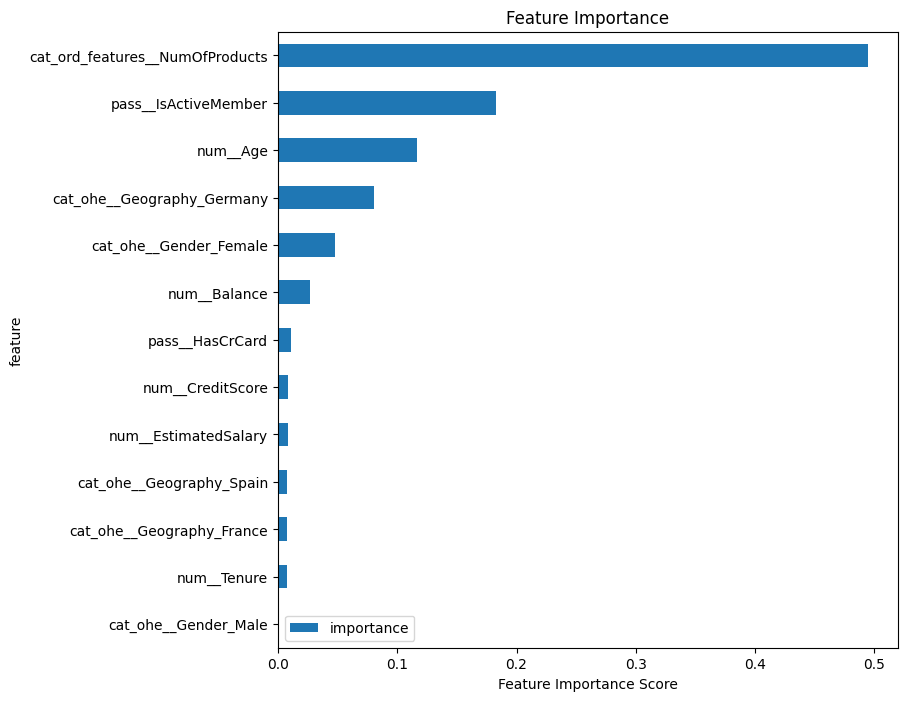

In [56]:
# plot the feature importance
def plot_feature_importance(model, X, y, top_n=10, figsize=(8, 8)):
    feat_imp = pd.DataFrame({'importance': model.feature_importances_})    
    feat_imp['feature'] = X.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title='Feature Importance', figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
plot_feature_importance(final_pipeline.named_steps['voting_classifier'].estimators_[0],
                        X_transformed,
                        train_df['Exited'],
                        top_n=20)


In [57]:
# create a dataframe of feature importance values sorted by importance
feature_importance = pd.DataFrame({'feature': X_transformed.columns,
                                      'importance': final_pipeline.named_steps['voting_classifier'].estimators_[0].feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance = feature_importance.set_index('feature', drop=True)
feature_importance.head(10)

,importance
feature,
cat_ord_features__NumOfProducts,0.494919
pass__IsActiveMember,0.182950
num__Age,0.116714
cat_ohe__Geography_Germany,0.080283
cat_ohe__Gender_Female,0.047533
num__Balance,0.026731
pass__HasCrCard,0.011181
num__CreditScore,0.008776
num__EstimatedSalary,0.008363


In [58]:
X = train_df
y = train_df['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


def objective(trial):
    params_xgb = {
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'tree_method': 'hist',  # Use GPU for training
        'device' : 'cuda',
        'eval_metric': 'auc',  # Evaluation metric
        'verbosity': 2,  # Set verbosity to 0 for less output
    }
    
    params_lgb = {
       'objective': 'binary',  # Objective for binary classification
       'boosting_type': 'gbdt',
       'device': 'gpu',
       'metric': 'auc',  # Evaluation metric
       'max_depth': trial.suggest_int('max_depth', 5, 10),
       'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
       'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
       'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
       'subsample': trial.suggest_float('subsample', 0.1, 1.0),
       'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
       'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
       'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
       'random_state': 42,
    }
    
    params_cb = {
       'iterations': trial.suggest_int('iterations', 200, 1000),
       'depth': trial.suggest_int('depth', 3, 50),
       'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 50),
       'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
    }

    xgb_model = XGBClassifier(**params_xgb)
    lgb_model = LGBMClassifier(**params_lgb)
    cb_model = CatBoostClassifier(**params_cb)

    classifiers = {
        'xgb_model': xgb_model,
        'lgb_model': lgb_model,
        'cb_model': cb_model
    }

    voting_clf = VotingClassifier(estimators=[(name, clf) for name, clf in classifiers.items()],
                                  voting='soft',
                                  n_jobs=-1)

    pipeline = Pipeline(steps=[
        ('drop_unwanted_columns', DropUnwantedColumns(columns=columns_to_drop)),
        ('preprocessor', preprocessor),
        ('voting_classifier', voting_clf)
    ])

    pipeline.fit(X_train, y_train)

    predictions = pipeline.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, predictions)

    return roc_auc

In [59]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-09 19:30:06,931] A new study created in memory with name: no-name-845130e7-85dd-4dae-b5a6-5cad0b1b2425


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-01-09 19:30:20,981] Trial 0 finished with value: 0.882082654908068 and parameters: {'n_estimators': 516, 'learning_rate': 0.009167358384629731, 'max_depth': 9, 'subsample': 0.09470070324570497, 'colsample_bytree': 0.1932138352538451, 'min_child_weight': 19, 'gamma': 0.6817851631783669, 'scale_pos_weight': 69.43574078735512, 'colsample_bylevel': 0.20797991685395573, 'min_child_samples': 1}. Best is trial 0 with value: 0.882082654908068.
[I 2024-01-09 19:30:33,057] Trial 1 finished with value: 0.8852039519920507 and parameters: {'n_estimators': 556, 'learning_rate': 0.009327863728848139, 'max_depth': 3, 'subsample': 0.7418407269468847, 'colsample_bytree': 0.7398228910858194, 'min_child_weight': 11, 'gamma': 0.6458471867558457, 'scale_pos_weight': 45.059897242266764, 'colsample_bylevel': 0.631869757559277, 'min_child_samples': 4}. Best is trial 1 with value: 0.8852039519920507.
[I 2024-01-09 19:30:45,405] Trial 2 finished with value: 0.8764967079610619 and parameters: {'n_estimato

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-01-09 19:31:30,308] Trial 4 finished with value: 0.8901864550498626 and parameters: {'n_estimators': 745, 'learning_rate': 0.005825436310946761, 'max_depth': 10, 'subsample': 0.9201060041043894, 'colsample_bytree': 0.5465648120489727, 'min_child_weight': 10, 'gamma': 0.5156684485679922, 'scale_pos_weight': 20.136502248454537, 'colsample_bylevel': 0.8651826093427933, 'min_child_samples': 3}. Best is trial 4 with value: 0.8901864550498626.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-01-09 19:31:49,552] Trial 5 finished with value: 0.8905314488536613 and parameters: {'n_estimators': 832, 'learning_rate': 0.010531993848225927, 'max_depth': 7, 'subsample': 0.5493617894059644, 'colsample_bytree': 0.7903343128058159, 'min_child_weight': 10, 'gamma': 0.9926381846198555, 'scale_pos_weight': 84.86653326015853, 'colsample_bylevel': 0.3793614669026534, 'min_child_samples': 4}. Best is trial 5 with value: 0.8905314488536613.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-01-09 19:32:03,349] Trial 6 finished with value: 0.8905262333818235 and parameters: {'n_estimators': 599, 'learning_rate': 0.014841958915318414, 'max_depth': 5, 'subsample': 0.7821901318153623, 'colsample_bytree': 0.5386241216514064, 'min_child_weight': 7, 'gamma': 0.8518726330612525, 'scale_pos_weight': 62.42006996278769, 'colsample_bylevel': 0.8628725772653297, 'min_child_samples': 3}. Best is trial 5 with value: 0.8905314488536613.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-01-09 19:32:21,028] Trial 7 finished with value: 0.8858119601089807 and parameters: {'n_estimators': 976, 'learning_rate': 0.012572792003015393, 'max_depth': 9, 'subsample': 0.38913835888325365, 'colsample_bytree': 0.39405859427453527, 'min_child_weight': 12, 'gamma': 0.7055549800552239, 'scale_pos_weight': 56.2291721457432, 'colsample_bylevel': 0.05210117505746945, 'min_child_samples': 8}. Best is trial 5 with value: 0.8905314488536613.
[I 2024-01-09 19:32:30,481] Trial 8 finished with value: 0.8884474014973978 and parameters: {'n_estimators': 674, 'learning_rate': 0.06783022281572748, 'max_depth': 2, 'subsample': 0.951228445978706, 'colsample_bytree': 0.6436824323799306, 'min_child_weight': 18, 'gamma': 0.8476694404051724, 'scale_pos_weight': 74.48944197992576, 'colsample_bylevel': 0.5605130211700131, 'min_child_samples': 11}. Best is trial 5 with value: 0.8905314488536613.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-01-09 19:32:42,554] Trial 9 finished with value: 0.8848140885733925 and parameters: {'n_estimators': 605, 'learning_rate': 0.010020847848847929, 'max_depth': 5, 'subsample': 0.9008876223959167, 'colsample_bytree': 0.2947003737815463, 'min_child_weight': 15, 'gamma': 0.032855992851970384, 'scale_pos_weight': 66.48223801851319, 'colsample_bylevel': 0.7466456292909557, 'min_child_samples': 9}. Best is trial 5 with value: 0.8905314488536613.


Number of finished trials:  10
Best trial:
  Value: 0.8905314488536613
  Params: 
    n_estimators: 832
    learning_rate: 0.010531993848225927
    max_depth: 7
    subsample: 0.5493617894059644
    colsample_bytree: 0.7903343128058159
    min_child_weight: 10
    gamma: 0.9926381846198555
    scale_pos_weight: 84.86653326015853
    colsample_bylevel: 0.3793614669026534
    min_child_samples: 4


In [64]:
params = trial.params

model_opt = xgb.XGBClassifier(**params)
    
# let's create a pipeline with our previous pipeline (preprocessor) and the model
xgb_opt = Pipeline(steps=[
    ('preprocessor', pipeline),
    ('xgboost', model_opt)
])

# let's train our model
xgb_opt.fit(train_df, train_df['Exited'])

# let's make predictions on the test set
predictions_optimized = xgb_opt.predict_proba(test_df)[:, 1]

In [65]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(estimator=xgb_pipe, 
                         X=train_df, 
                         y=train_df['Exited'], 
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose=1)


scores_opt = cross_val_score(estimator=xgb_opt, 
                         X=train_df, 
                         y=train_df['Exited'], 
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose=1)

# print scores and scores_opt
print('ROC AUC scores for the 10 folds: ', scores)
print('Mean ROC AUC score: %.3f' % scores.mean())

print('ROC AUC scores for the 10 folds: ', scores_opt)
print('Mean ROC AUC score: %.3f' % scores_opt.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


ROC AUC scores for the 10 folds:  [0.88942587 0.88541528 0.88847853 0.88537149 0.88457075 0.89307202
 0.88567355 0.88969507 0.88567    0.8826853 ]
Mean ROC AUC score: 0.887
ROC AUC scores for the 10 folds:  [0.89064175 0.88620064 0.88931415 0.88751724 0.88606502 0.89395222
 0.8878637  0.8924183  0.88743792 0.88508458]
Mean ROC AUC score: 0.889


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.4s finished


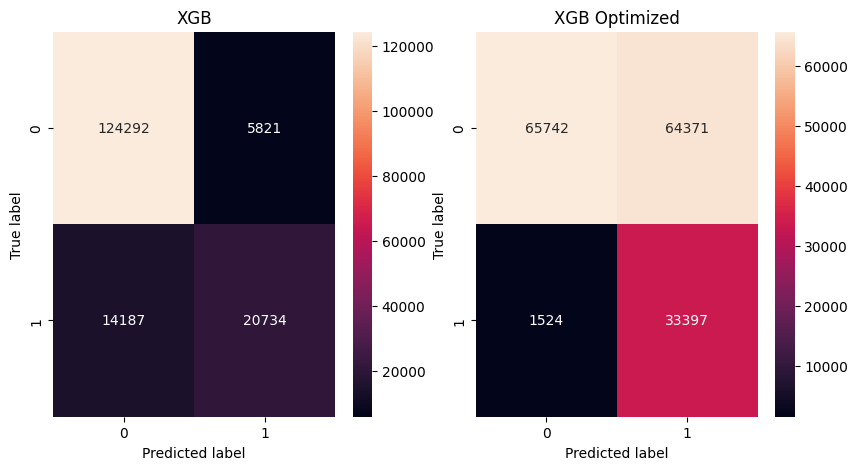

In [66]:
# plot confusion matrix for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(confusion_matrix(train_df['Exited'], xgb_pipe.predict(train_df)), annot=True, fmt='d', ax=ax1)
sns.heatmap(confusion_matrix(train_df['Exited'], xgb_opt.predict(train_df)), annot=True, fmt='d', ax=ax2)
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
plt.show()

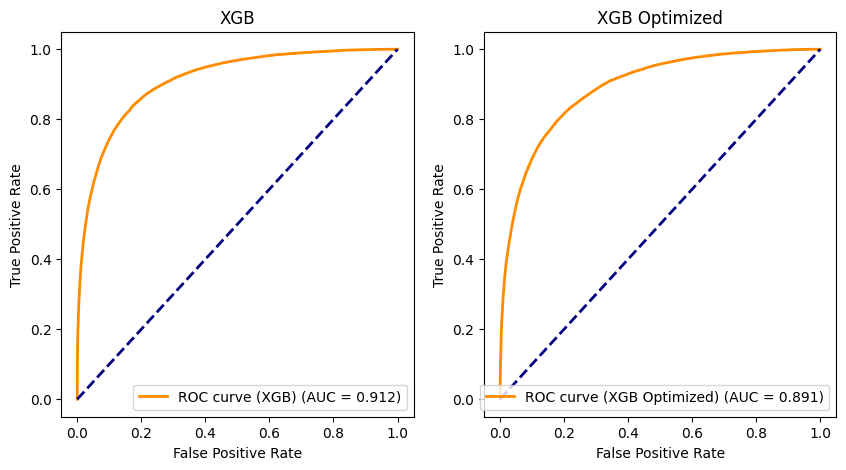

In [67]:
# plot roc curve for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fpr_xgb, tpr_xgb, _ = roc_curve(train_df['Exited'], xgb_pipe.predict_proba(train_df)[:, 1])
fpr_xgb_opt, tpr_xgb_opt, _ = roc_curve(train_df['Exited'], xgb_opt.predict_proba(train_df)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_xgb_opt = auc(fpr_xgb_opt, tpr_xgb_opt)
ax1.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (XGB) (AUC = %0.3f)' % roc_auc_xgb)
ax2.plot(fpr_xgb_opt, tpr_xgb_opt, color='darkorange', lw=2, label='ROC curve (XGB Optimized) (AUC = %0.3f)' % roc_auc_xgb_opt)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")
ax2.legend(loc="lower right")
plt.show()


[learning_curve] Training set sizes: [  1485  17823  34161  50500  66838  83176  99515 115853 132191 148530]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.2s finished


[learning_curve] Training set sizes: [  1485  17823  34161  50500  66838  83176  99515 115853 132191 148530]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.6s finished


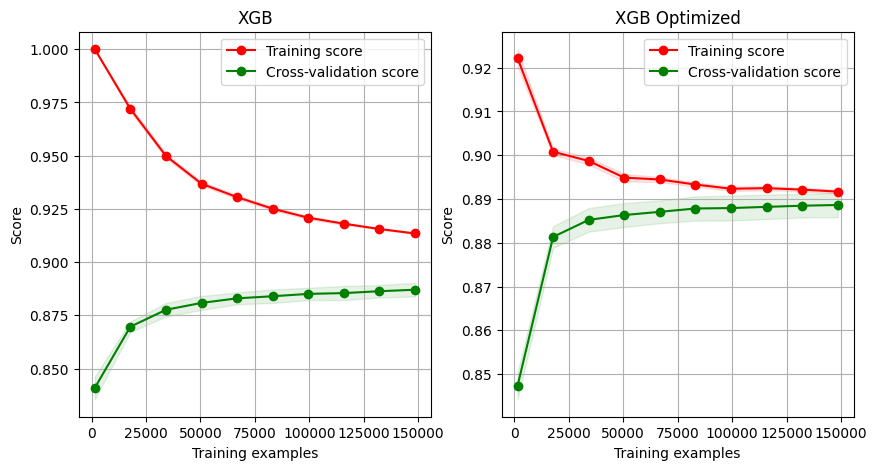

In [68]:
# plot learning curve for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
train_sizes, train_scores, test_scores = learning_curve(xgb_pipe, train_df, train_df['Exited'], cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10), verbose=1)
train_sizes_opt, train_scores_opt, test_scores_opt = learning_curve(xgb_opt, train_df, train_df['Exited'], cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10), verbose=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean_opt = np.mean(train_scores_opt, axis=1)
train_scores_std = np.std(train_scores, axis=1)
train_scores_std_opt = np.std(train_scores_opt, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean_opt = np.mean(test_scores_opt, axis=1)
test_scores_std = np.std(test_scores, axis=1)
test_scores_std_opt = np.std(test_scores_opt, axis=1)
ax1.grid()
ax2.grid()
ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
ax2.fill_between(train_sizes_opt, train_scores_mean_opt - train_scores_std_opt, train_scores_mean_opt + train_scores_std_opt, alpha=0.1, color='r')
ax2.fill_between(train_sizes_opt, test_scores_mean_opt - test_scores_std_opt, test_scores_mean_opt + test_scores_std_opt, alpha=0.1, color='g')
ax1.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
ax1.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
ax2.plot(train_sizes_opt, train_scores_mean_opt, 'o-', color='r', label='Training score')
ax2.plot(train_sizes_opt, test_scores_mean_opt, 'o-', color='g', label='Cross-validation score')
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_xlabel('Training examples')
ax1.set_ylabel('Score')
ax2.set_xlabel('Training examples')
ax2.set_ylabel('Score')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

## 3) Submission

In [36]:
# add to submission dataframe
submission['Exited'] = predictions_optimized

# save to csv
submission.to_csv('data/submission_9.csv', index=False)

# Best value for my model was: 0.88628 - submission 7